<a href="https://colab.research.google.com/github/Jameslorry6666/Micheal.iml/blob/master/mnist_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# To view Model Summary
!pip install -q torchinfo

#Please note, MLP is not always use for image classification, better use CNN. MLP is always use to predict classification of house by mapping out different compartment

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import time

%matplotlib inline

#set seed and fix it to cuda(GPU) if avaialble if not use CPU

In [ ]:
def set_seeds():
    # set random seed value
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
    # Fix seed to make training deterministic.
    if torch.cuda.is_available():
       torch.cuda.manual_seed(SEED_VALUE)
       torch.cuda.manual_seed_all(SEED_VALUE)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = True

set_seeds()

#prepare dataloader

In [ ]:
#Convert to Tensors and Normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # mean, std
])

# Download and load the training data
train_set = datasets.FashionMNIST(root = "F_MNIST_data", download = True, train = True, transform = transform)
val_set = datasets.FashionMNIST(root = "F_MNIST_data", download = True, train = False, transform = transform) #Test set

print("Total Train Images: ", len(train_set))
print("Total Val Images: ", len(val_set))

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.7MB/s]

Total Train Images:  60000
Total Val Images:  10000


In [ ]:
batch_size = 64

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle = True, batch_size = 64)
val_loader = torch.utils.data.DataLoader(val_set, shuffle = False, batch_size = 64)

In [ ]:
#class to idx mapping
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"  }

# Dataset visualization

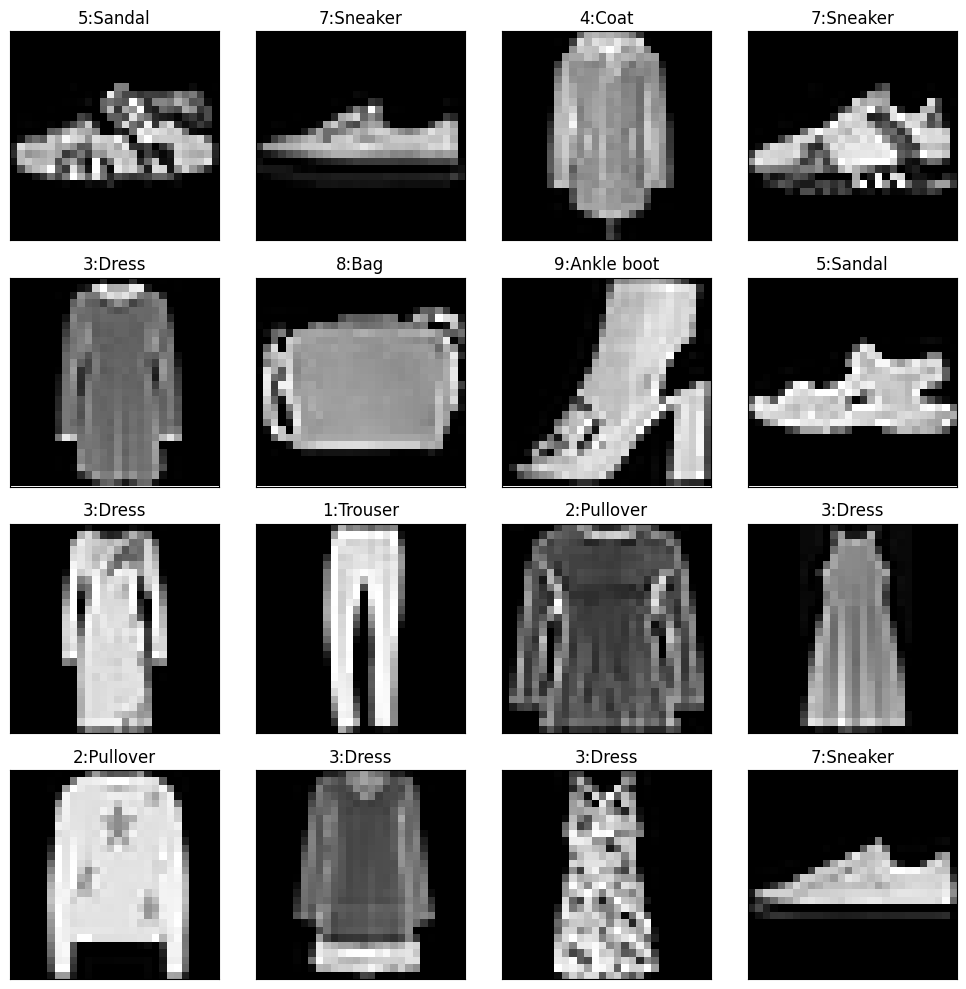

In [ ]:
def visualize_images(trainloader, num_images=20):
    fig = plt.figure(figsize=(10, 10))

    # Iterate over the first batch
    images, labels = next(iter(trainloader))

    #To calculate the number of rows and columns for subplots
    num_rows = 4
    num_cols = int(np.ceil(num_images / num_rows))

    for idx in range(min(num_images, len(images))):
      image, label = images[idx], labels[idx]

      ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(image), cmap="gray")
      ax.set_title(f"{label.item()}:{class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

visualize_images(train_loader, num_images=16)

# Multi Layer Perceptron Model Implementation(Model architechure)

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc0 = nn.Linear(784, 512)
        self.bn0 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64,num_classes)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        #Flatten the input tensor
        x = x.view(x.shape[0], -1) #(B,784)  --> 28x28 = 784
        # First fully connected layer with ReLU, batch norm, and dropout
        x = F.relu(self.bn0(self.fc0(x)))
        x = self.dropout(x)

        x = F.relu(self.bn1(self.fc1(x)))

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        # Output layer with softmax activation
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim = 1)

        return x

# Instantiate the model.
mlp_model = MLP(num_classes = 10)

In [ ]:
#A dummy input size of (B,C,H,W) = (1,1,28,28) is passed.
print(summary(mlp_model, input_size = (1,1,28,28), row_settings = ["var_names"]))
# Display the model summary.

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Dropout (dropout)                      [1, 128]                  --
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable

#Training configuration

In [ ]:
criterion = F.nll_loss #Negative Log Likelihood Loss
optimizer = optim.Adam(mlp_model.parameters(), lr = 1e-2) #0.01
num_epochs = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#Model training

In [ ]:
def train(model, trainloader, criterion, optimizer,DEVICE):
    model.train()
    model.to(DEVICE)
    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    for images, labels in trainloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [ ]:
def validation(model, val_loader, criterion,DEVICE):
    model.eval()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images,labels = images.to(DEVICE),labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) #(B, class_id)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [ ]:
def main(model, trainloader, val_loader, epochs=5, DEVICE = "cuda"):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, DEVICE)
        val_loss, val_accuracy = validation(model, val_loader, criterion, DEVICE)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1:0>2}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Epoch 01/40 - Train Loss: 0.5639, Train Accuracy: 79.86% - Val Loss: 0.4358, Val Accuracy: 84.48%
Epoch 02/40 - Train Loss: 0.4391, Train Accuracy: 84.45% - Val Loss: 0.3814, Val Accuracy: 85.58%
Epoch 03/40 - Train Loss: 0.3964, Train Accuracy: 85.92% - Val Loss: 0.3885, Val Accuracy: 85.66%
Epoch 04/40 - Train Loss: 0.3749, Train Accuracy: 86.57% - Val Loss: 0.3490, Val Accuracy: 87.54%
Epoch 05/40 - Train Loss: 0.3549, Train Accuracy: 87.32% - Val Loss: 0.3431, Val Accuracy: 87.58%
Epoch 06/40 - Train Loss: 0.3392, Train Accuracy: 87.66% - Val Loss: 0.3384, Val Accuracy: 87.55%
Epoch 07/40 - Train Loss: 0.3260, Train Accuracy: 88.04% - Val Loss: 0.3270, Val Accuracy: 88.02%
Epoch 08/40 - Train Loss: 0.3136, Train Accuracy: 88.55% - Val Loss: 0.3319, Val Accuracy: 87.83%
Epoch 09/40 - Train Loss: 0.3062, Train Accuracy: 88.86% - Val Loss: 0.3300, Val Accuracy: 88.31%
Epoch 10/40 - Train Loss: 0.2947, Train Accuracy: 89.30% - Val Loss: 0.3265, Val Accuracy: 88.34%
Epoch 11/40 - Train 

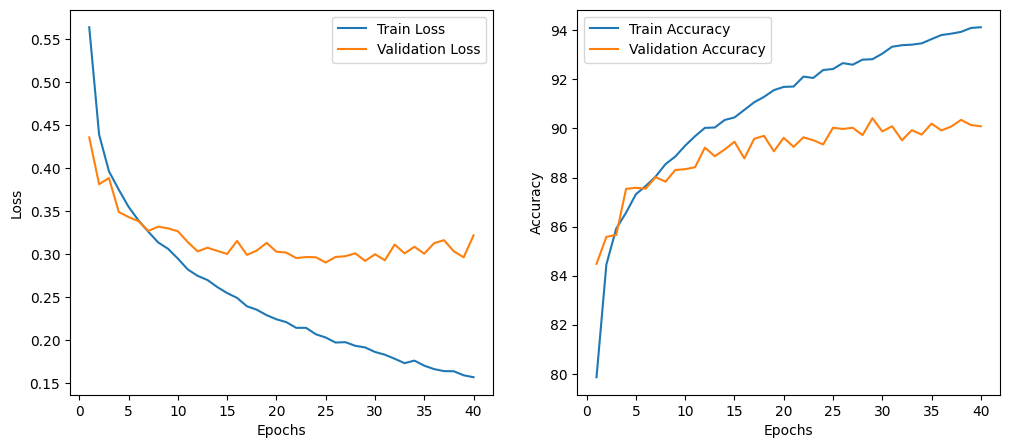

In [ ]:
main(mlp_model, train_loader, val_loader, epochs = num_epochs, DEVICE = DEVICE)

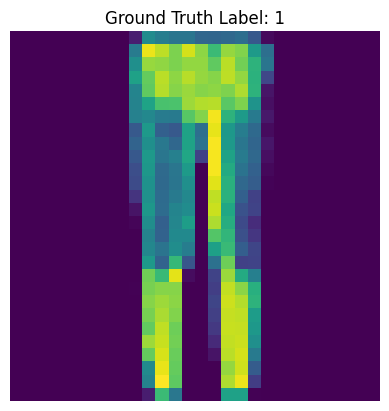

In [ ]:
images, gt_labels = next(iter(val_loader))

rand_idx = random.choice(range(len(images)))

plt.imshow(images[rand_idx].squeeze())
plt.title("Ground Truth Label: " + str(int(gt_labels[rand_idx])), fontsize = 12)
plt.axis("off")
plt.show()


In [ ]:
# Formatting
bold = f"\033[1m"
reset = f"\033[0m"

In [ ]:
mlp_model.eval()

with torch.no_grad():
     batch_outputs = mlp_model(images.to(DEVICE))

prob_score_batch = batch_outputs.softmax(dim=1).cpu()

prob_score_test_image = prob_score_batch[rand_idx]
pred_cls_id = prob_score_test_image.argmax()

print("Predictions for each class on the test image:\n")

for idx, cls_prob in enumerate(prob_score_test_image):
    if idx == pred_cls_id:
       print(f"{bold}Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}{reset}")
    else:
       print(f"Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}")

Predictions for each class on the test image:

Class: 0 - T-shirt/top, Probability: 0.000
Class: 1 - Trouser, Probability: 1.000
Class: 2 - Pullover, Probability: 0.000
Class: 3 - Dress, Probability: 0.000
Class: 4 - Coat, Probability: 0.000
Class: 5 - Sandal, Probability: 0.000
Class: 6 - Shirt, Probability: 0.000
Class: 7 - Sneaker, Probability: 0.000
Class: 8 - Bag, Probability: 0.000
Class: 9 - Ankle boot, Probability: 0.000


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [ ]:
def prediction_batch(model, batch_inputs):
    model.eval()

    batch_outputs = model(batch_inputs)

    with torch.no_grad():
        batch_probs = batch_outputs.softmax(dim=1) #along num of classes dimension

    batch_cls_ids = batch_probs.argmax(dim=1)

    return batch_cls_ids.cpu()

In [ ]:
val_target_labels = []
val_predicted_labels = []

for image_batch, target_batch in val_loader:
    image_batch = image_batch.to(DEVICE)

    batch_pred_cls_id = prediction_batch(mlp_model, image_batch)

    val_predicted_labels.append(batch_pred_cls_id)
    val_target_labels.append(target_batch)

val_target_labels = torch.cat(val_target_labels).numpy()
val_predicted_labels = torch.cat(val_predicted_labels).numpy()

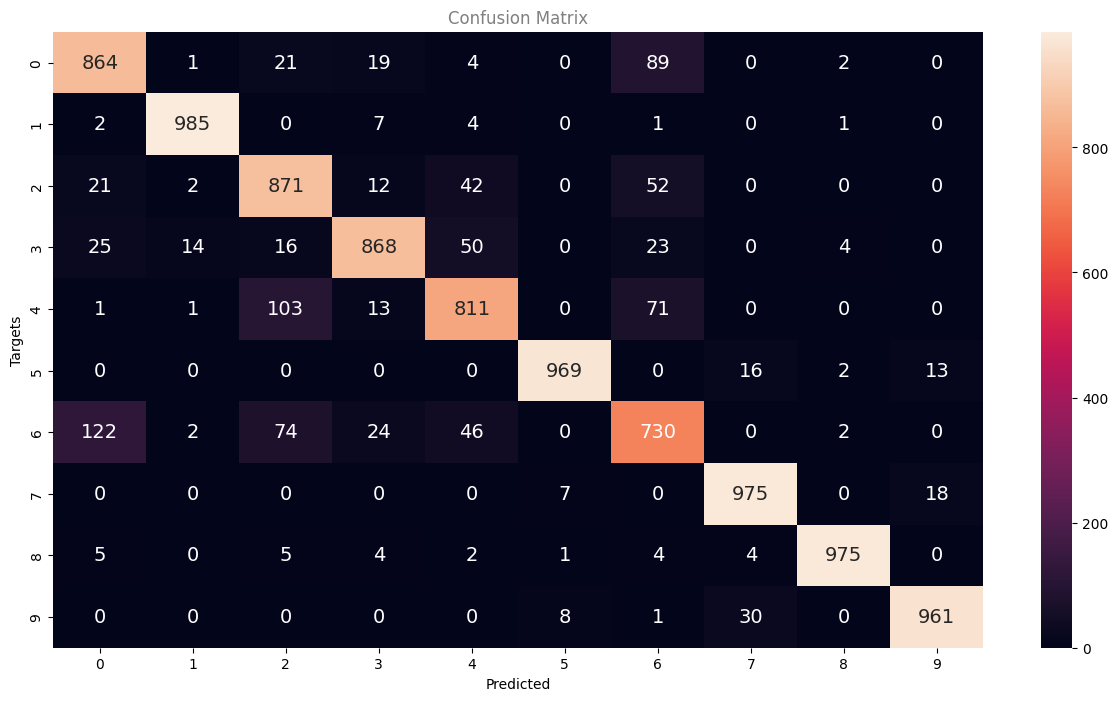

In [ ]:
cm = confusion_matrix(y_true=val_target_labels, y_pred = val_predicted_labels)

plt.figure(figsize= [15,8])

# Plot the confusion matrix as a heatmap.
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size":14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()